- 범주형 변수의 label encoder 
- Pytorch 의 TabNet 모델 활용
- 피쳐별 중요도 확인 가능.

In [ ]:
# pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import skew
import gc
from sklearn.linear_model import Ridge , LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from preprocessing import ct_df_ver05, ct_df_ver0
from lossfunction import rmse, mse, mae, mape, r_squared, adjusted_r_squared
import time
from tqdm import tqdm
import torch
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

DR                    0
PROCESS_ID            0
PART_ID               0
LOTTYPE               0
QTY                   0
HOLD_FLAG           174
FLOORID               0
GRADE              2911
COMPLETE_RATE         0
LOT_PURPOSE           0
DUE_DATE           1801
WIPTURN            1801
ROOM                  0
PROCESS_GROUP         0
LAYER_TITLE           0
LAYER_GROUP           0
BLOCK_GROUP           0
EQPTYPE               0
MOVE_0                0
EQP_WORKLOAD_0        0
MOVE_1                0
EQP_WORKLOAD_1        0
MOVE_2                0
EQP_WORKLOAD_2        0
BATCH              3391
Q_E                  73
Q_P                 220
L_E                   0
L_P                   0
Q_H                  82
Q_R                 296
Q_W                 209
L_H                   0
L_R                   0
L_W                   0
Q_2                3567
Q_3                 427
Q_4                 637
Q_5                1107
Q_7                2618
Q_8                2194
Q_10            

g:\내 드라이브\git\tabular_DL\preprocessing.py:95: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ct_df_ver0.corr()


원핫인코딩 결과:  (3924, 586) 바이너리인코딩 결과:  (3924, 107)
(3924, 57) (3924,)
(3139, 57) (785, 57) (3139,) (785,) <class 'pandas.core.series.Series'>
(3139, 57) (785, 57) (3139,) (785,)


In [2]:
ct_df_ver05.shape

(3924, 58)

In [3]:
# ▶ 숫자형, 범주형 변수 분할
numerical_list=[]
categorical_list=[]

for i in ct_df_ver05.columns :
  if ct_df_ver05[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list {}:".format(len(categorical_list)), categorical_list)
print("numerical_list {}:".format(len(numerical_list)), numerical_list)

categorical_list 15: ['DR', 'PROCESS_ID', 'PART_ID', 'LOTTYPE', 'HOLD_FLAG', 'FLOORID', 'LOT_PURPOSE', 'ROOM', 'PROCESS_GROUP', 'LAYER_TITLE', 'LAYER_GROUP', 'BLOCK_GROUP', 'EQPTYPE', 'BATCH', 'SHIFT_TYPE']
numerical_list 43: ['QTY', 'GRADE', 'COMPLETE_RATE', 'DUE_DATE', 'WIPTURN', 'MOVE_0', 'EQP_WORKLOAD_0', 'MOVE_1', 'EQP_WORKLOAD_1', 'MOVE_2', 'EQP_WORKLOAD_2', 'Q_E', 'Q_P', 'L_E', 'L_P', 'Q_H', 'Q_R', 'Q_W', 'L_H', 'L_R', 'L_W', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_7', 'Q_8', 'Q_10', 'L_2', 'L_3', 'L_4', 'L_5', 'L_7', 'L_8', 'L_10', 'WIP_WAITTIME', 'WIP_PRODUCT_NUM', 'PROCESSTIME', 'PRC_WAIT_MIN', 'PRC_WAIT_MAX', 'PRC_WAIT_MEDIAN', 'PRC_WAIT_STD', 'WAITTIME']


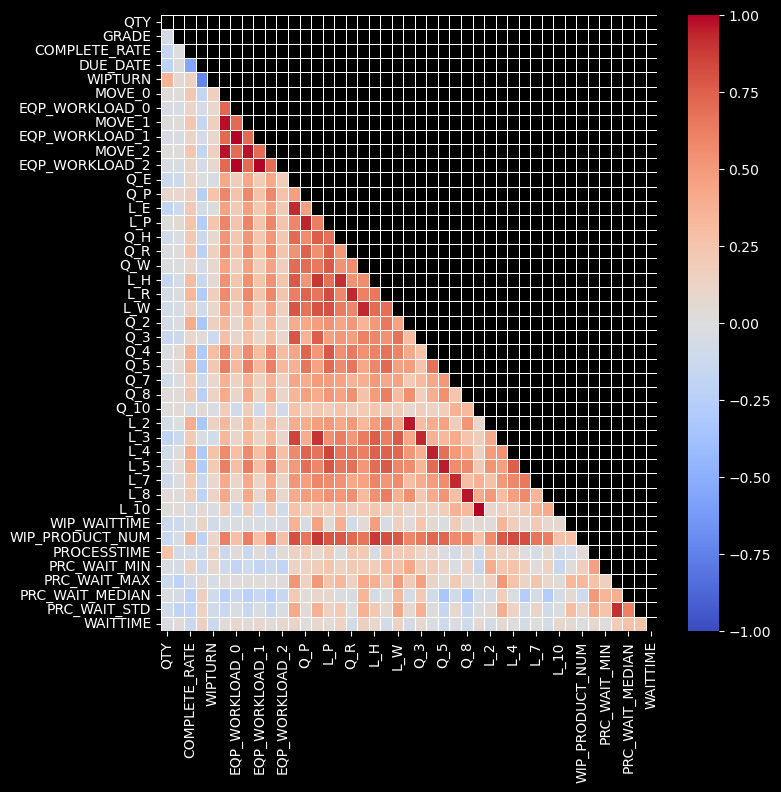

In [5]:
# corr() 활용, numerical value 상관관계 확인
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

fig = plt.figure(figsize=(8,8))
df_num = ct_df_ver05[numerical_list].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', linewidths=.5,mask=np.triu(df_num.corr()));

In [6]:
# 상관계수 중 target 변수인 SalePrice 열(col)만 가져오기
df_corr_y = pd.DataFrame(abs(df_num['WAITTIME']).sort_values(ascending=False))
# 피어슨 상관계수 절대값 기준 0.1 초과 Selection
n_features = list(df_corr_y[abs(df_corr_y['WAITTIME']) > 0.1].index)

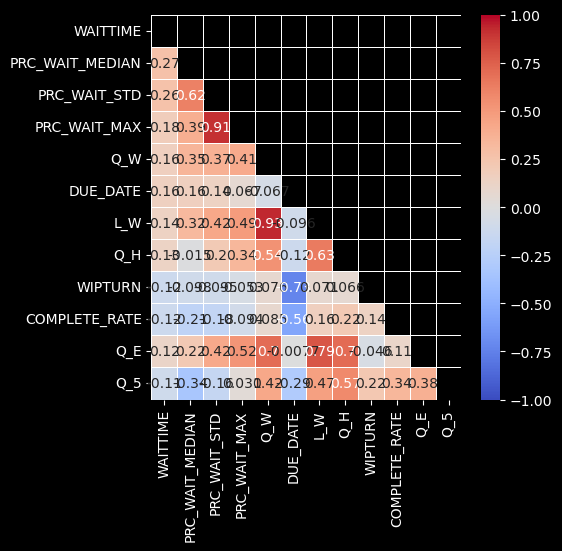

In [13]:
# ▶ corr() 활용, numerical value 상관관계 확인
fig = plt.figure(figsize=(5,5))
df_num = ct_df_ver05[n_features].corr()
sns.heatmap(df_num, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, mask=np.triu(df_num.corr()));

In [14]:
# 카테고리 변수의 항목별 타겟 변수 평균과, 비율 등 확인
# ▶ df로 변경
list_of_df = []
ct_df_ver05['WAITTIME'] = np.expm1(ct_df_ver05['WAITTIME'])

for var in categorical_list :
  temp = ct_df_ver05.groupby(var)['WAITTIME'].agg(['count', 'mean']).sort_values(by=['mean'], ascending=False)
  temp['lift'] = temp['mean'] / ct_df_ver05['WAITTIME'].mean()
  temp['ratio'] = round((temp['count'] / len(ct_df_ver05))*100,2)
  print(temp)
  print('______________________________________________________________')
ct_df_ver05['WAITTIME'] = np.log1p(ct_df_ver05['WAITTIME'])

    count         mean      lift  ratio
DR                                     
N8    187  1217.437112  1.355068   4.77
N3   1623  1003.776525  1.117253  41.36
N4   1462   855.331984  0.952027  37.26
N5    652   641.356319  0.713861  16.62
______________________________________________________________
            count         mean      lift  ratio
PROCESS_ID                                     
SZ             15  2509.330000  2.793008   0.38
YB             48  1564.032917  1.740846   1.22
QG             81  1393.777778  1.551344   2.06
ZS            168  1243.015655  1.383538   4.28
QJ            106  1082.686226  1.205083   2.70
SY            168  1080.507976  1.202659   4.28
Z8             48  1047.010625  1.165375   1.22
0B             32  1044.677812  1.162778   0.82
ZR            135  1011.027037  1.125323   3.44
ZP            400   992.480950  1.104680  10.19
XP            166   964.584759  1.073631   4.23
RQ            276   957.319819  1.065544   7.03
CU             58   909.6

In [ ]:
'''
c_features = categorical_list
features_list = n_features + c_features
ct_df_ver05 = ct_df_ver05[features_list]
ct_df_ver05.shape'''

'\nc_features = categorical_list\nfeatures_list = n_features + c_features\nct_df_ver05 = ct_df_ver05[features_list]\nct_df_ver05.shape'

In [15]:
# TabNet의 범주형 변수처리를 위한 LabelEncoding : 카테고리 데이터의 Level에 증가하는 숫자를 부여
from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims =  {}
for col in categorical_list:
    print(col, ct_df_ver05[col].nunique())
    l_enc = LabelEncoder()
    ct_df_ver05[col] = l_enc.fit_transform(ct_df_ver05[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

DR 4
PROCESS_ID 21
PART_ID 27
LOTTYPE 12
HOLD_FLAG 2
FLOORID 4
LOT_PURPOSE 6
ROOM 8
PROCESS_GROUP 237
LAYER_TITLE 156
LAYER_GROUP 15
BLOCK_GROUP 7
EQPTYPE 49
BATCH 2
SHIFT_TYPE 8


In [18]:
print(categorical_columns, categorical_dims, sep='\n')

['DR', 'PROCESS_ID', 'PART_ID', 'LOTTYPE', 'HOLD_FLAG', 'FLOORID', 'LOT_PURPOSE', 'ROOM', 'PROCESS_GROUP', 'LAYER_TITLE', 'LAYER_GROUP', 'BLOCK_GROUP', 'EQPTYPE', 'BATCH', 'SHIFT_TYPE']
{'DR': 4, 'PROCESS_ID': 21, 'PART_ID': 27, 'LOTTYPE': 12, 'HOLD_FLAG': 2, 'FLOORID': 4, 'LOT_PURPOSE': 6, 'ROOM': 8, 'PROCESS_GROUP': 237, 'LAYER_TITLE': 156, 'LAYER_GROUP': 15, 'BLOCK_GROUP': 7, 'EQPTYPE': 49, 'BATCH': 2, 'SHIFT_TYPE': 8}


In [19]:
# ▶ Define categorical features for categorical embeddings
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함

features = [ col for col in ct_df_ver05.columns if col not in ['WAITTIME']]
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [20]:
# Separate target and feature
y_ct = ct_df_ver05['WAITTIME']
x_ct = ct_df_ver05.drop(columns='WAITTIME')

# Split the data into train (60%) and a temporary set (40%)
x_train, x_temp, y_train, y_temp = train_test_split(x_ct, y_ct, test_size=0.4, random_state=11)

# Split the temporary set into validation (20%) and test sets (20%)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=11)

print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)


(2354, 57) (785, 57) (785, 57) (2354,) (785,) (785,)


In [21]:
x_train = x_train.values
x_valid = x_valid.values
x_test = x_test.values

y_train = y_train.values.reshape(-1, 1)
y_valid = y_valid.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [23]:
# ▶ TabNet을 활용하기 위해서는 카테고리 변수와 dim을 전달해야 함
# ▶ cat_emb_dim : List of embeddings size for each categorical features.
'''pip install pytorch-tabnet'''
from pytorch_tabnet.tab_model import TabNetRegressor
reg = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=7, cat_idxs=cat_idxs, verbose=10)

c:\Users\bmseo\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [24]:
# ▶ 모델 학습
# ▶ patience = Number of consecutive epochs without improvement before performing early stopping.
max_epochs = 200

model = reg.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)], # 학습-검증 셋을 입력해서 하이퍼 파라미터 튜닝시킴
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=max_epochs,
    patience=300  # early stopping 기능
)

epoch 0  | loss: 31.95011| train_mse: 36.25682| valid_mse: 34.34838|  0:00:00s
epoch 10 | loss: 2.70698 | train_mse: 50.72493| valid_mse: 55.61784|  0:00:07s
epoch 20 | loss: 2.0297  | train_mse: 12.853  | valid_mse: 12.89457|  0:00:12s
epoch 30 | loss: 1.8625  | train_mse: 9.20874 | valid_mse: 9.16771 |  0:00:18s
epoch 40 | loss: 1.70327 | train_mse: 5.27911 | valid_mse: 5.55844 |  0:00:23s
epoch 50 | loss: 1.55668 | train_mse: 4.09175 | valid_mse: 4.24434 |  0:00:29s
epoch 60 | loss: 1.41067 | train_mse: 3.68962 | valid_mse: 4.06631 |  0:00:37s
epoch 70 | loss: 1.32677 | train_mse: 2.52187 | valid_mse: 3.00225 |  0:00:43s
epoch 80 | loss: 1.25304 | train_mse: 2.03243 | valid_mse: 2.6543  |  0:00:49s
epoch 90 | loss: 1.09703 | train_mse: 1.71946 | valid_mse: 2.39584 |  0:00:55s
epoch 100| loss: 0.99944 | train_mse: 1.38157 | valid_mse: 2.26067 |  0:01:00s
epoch 110| loss: 0.94337 | train_mse: 1.2236  | valid_mse: 2.18216 |  0:01:06s
epoch 120| loss: 0.87097 | train_mse: 1.02215 | vali

c:\Users\bmseo\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


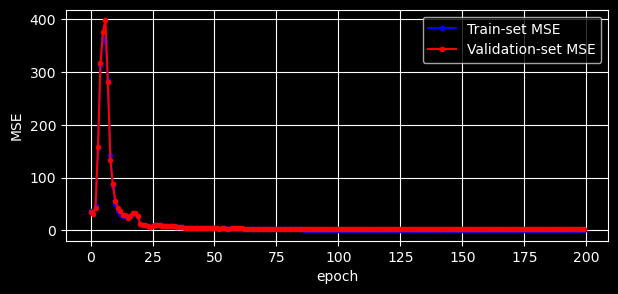

In [25]:
# ▶ Train, Validation Set 성능 비교
train_mse = reg.history['train_mse']
val_mse = reg.history['valid_mse']

x_len = np.arange(len(val_mse))
plt.figure(figsize=(7, 3))
plt.plot(x_len, train_mse, marker='.', c='blue', label="Train-set MSE")
plt.plot(x_len, val_mse, marker='.', c='red', label="Validation-set MSE")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [26]:
# 테스트셋의 성능 예측

preds = reg.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

MSE = mean_squared_error(y_test, preds)
MAE = mean_absolute_error(y_test, preds)
R2 = r2_score(y_test, preds)

print(MSE, MAE, R2)

2.1709120943356317 1.1598419728122555 0.017674882932052105


In [27]:
features_list = x_ct.columns
len(features_list)

explain_matrix, masks = reg.explain(x_test)
len(explain_matrix[0])

57

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56.]),
 [Text(0.0, 0, 'DR'),
  Text(1.0, 0, 'PROCESS_ID'),
  Text(2.0, 0, 'PART_ID'),
  Text(3.0, 0, 'LOTTYPE'),
  Text(4.0, 0, 'QTY'),
  Text(5.0, 0, 'HOLD_FLAG'),
  Text(6.0, 0, 'FLOORID'),
  Text(7.0, 0, 'GRADE'),
  Text(8.0, 0, 'COMPLETE_RATE'),
  Text(9.0, 0, 'LOT_PURPOSE'),
  Text(10.0, 0, 'DUE_DATE'),
  Text(11.0, 0, 'WIPTURN'),
  Text(12.0, 0, 'ROOM'),
  Text(13.0, 0, 'PROCESS_GROUP'),
  Text(14.0, 0, 'LAYER_TITLE'),
  Text(15.0, 0, 'LAYER_GROUP'),
  Text(16.0, 0, 'BLOCK_GROUP'),
  Text(17.0, 0, 'EQPTYPE'),
  Text(18.0, 0, 'MOVE_0'),
  Text(19.0, 0, 'EQP_WORKLOAD_0'),
  Text(20.0, 0, 'MOVE_1'),
  Text(21.0, 0, 'EQP_WORKLOAD_1'),
  Text(22.0, 0, 'MOVE_2'),
  Text(2

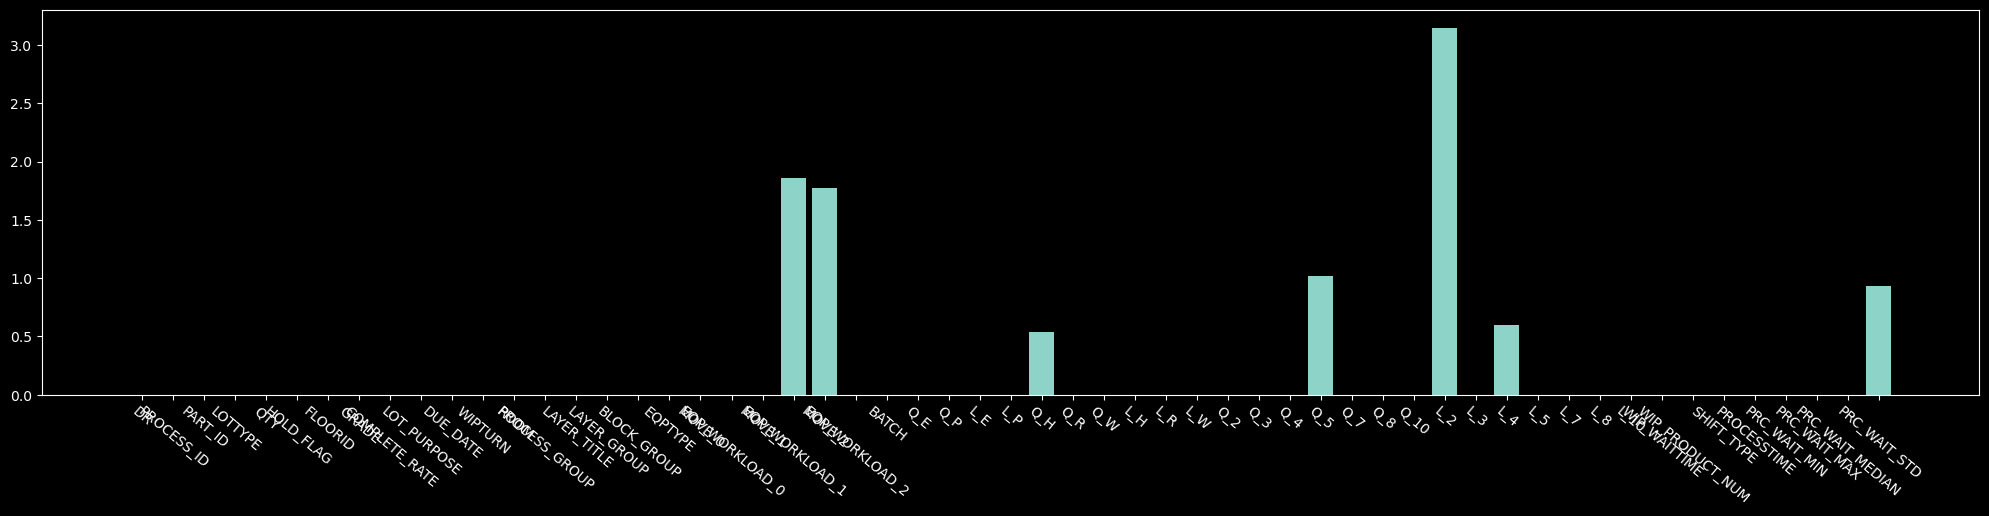

In [28]:
# ▶ 개별 값 변수 중요도
# ▶ 영향을 끼친 변수는 0으로 출력
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

features_list = x_ct.columns

explain_matrix, masks = reg.explain(x_test)

fig = plt.figure(figsize=(25,5));
# explain_matrix[0] = x_test의 첫번째 데이터에 대해서만 로컬로 중요도 파악 [] 안에 숫자를 바꿔가며 데이터별 중요도 파악가능
plt.bar(features_list[:], explain_matrix[2]);
plt.xticks(features_list[:]);
plt.xticks(rotation=-40)

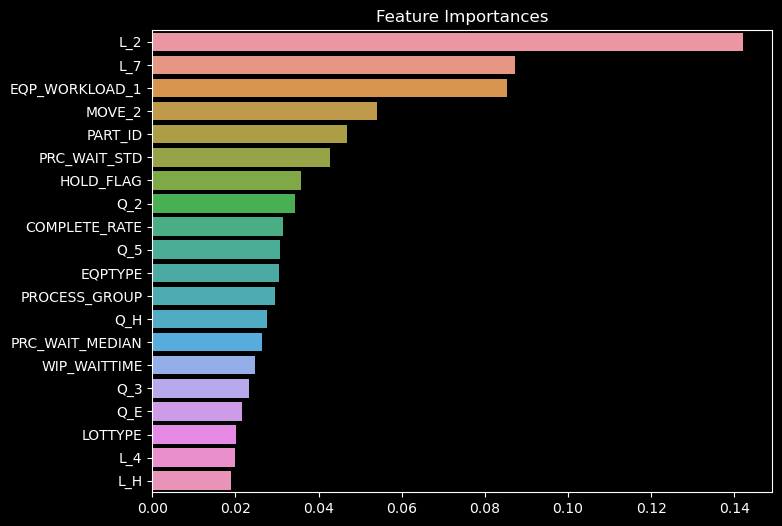

In [29]:
# ▶ Global 영향도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = features_list[:])
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()